In [1]:
import os

import keras
from keras import layers, ops, mixed_precision
from keras.optimizers import AdamW
import numpy as np
import random
from matplotlib import pyplot as plt

# Set seed for reproducibility.
keras.utils.set_random_seed(42)

2025-10-23 10:01:15.798928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = {
    "mixed_precision": True,
    "dataset": "cifar10",
    "train_slice": 40_000,
    "batch_size": 50, #FIX THIS TO YOUR HARDWARE LIMITATIONS
    "buffer_size": 2048 * 2,
    "input_shape": [32, 32, 3],
    "image_size": 48,
    "num_classes": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "epochs": 30,
    "patch_size": 4,
    "embed_dim": 64,
    "chunk_size": 8,
    "r": 2,
    "num_layers": 4,
    "ffn_drop": 0.2,
    "attn_drop": 0.2,
    "num_heads": 1,
}

if config["mixed_precision"]:
    policy = mixed_precision.Policy("mixed_float16")
    mixed_precision.set_global_policy(policy)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[: config["train_slice"]], y_train[: config["train_slice"]]),
    (x_train[config["train_slice"] :], y_train[config["train_slice"] :]),
)

In [4]:
# Build the `train` augmentation pipeline.
train_augmentation = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(
            config["input_shape"][0] + 20,
            config["input_shape"][0] + 20,
            dtype="float32",
        ),
        layers.RandomCrop(config["image_size"], config["image_size"], dtype="float32"),
        layers.RandomFlip("horizontal", dtype="float32"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_augmentation = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(config["image_size"], config["image_size"], dtype="float32"),
    ],
    name="test_data_augmentation",
)

# We define functions in place of simple lambda functions to run through the
# [`keras.Sequential`](/api/models/sequential#sequential-class)in order to solve this warning:
# (https://github.com/tensorflow/tensorflow/issues/56089)


def train_map_fn(image, label):
    return train_augmentation(image), label


def test_map_fn(image, label):
    return test_augmentation(image), label

I0000 00:00:1761206517.726945   15585 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8698 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [5]:
class Dataset(keras.utils.PyDataset):
    def __init__(
        self, x_data, y_data, batch_size, preprocess_fn=None, shuffle=False, **kwargs
    ):
        if shuffle:
            perm = np.random.permutation(len(x_data))
            x_data = x_data[perm]
            y_data = y_data[perm]
        self.x_data = x_data
        self.y_data = y_data
        self.preprocess_fn = preprocess_fn
        self.batch_size = batch_size
        super().__init__(*kwargs)

    def __len__(self):
        return len(self.x_data) // self.batch_size

    def __getitem__(self, idx):
        batch_x, batch_y = [], []
        for i in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            x, y = self.x_data[i], self.y_data[i]
            if self.preprocess_fn:
                x, y = self.preprocess_fn(x, y)
            batch_x.append(x)
            batch_y.append(y)
        batch_x = ops.stack(batch_x, axis=0)
        batch_y = ops.stack(batch_y, axis=0)
        return batch_x, batch_y


train_ds = Dataset(
    x_train, y_train, config["batch_size"], preprocess_fn=train_map_fn, shuffle=True
)
val_ds = Dataset(x_val, y_val, config["batch_size"], preprocess_fn=test_map_fn)
test_ds = Dataset(x_test, y_test, config["batch_size"], preprocess_fn=test_map_fn)

In [6]:
class PatchEmbedding(layers.Layer):
    """Image to Patch Embedding.
    Args:
        image_size (`Tuple[int]`): Size of the input image.
        patch_size (`Tuple[int]`): Size of the patch.
        embed_dim (`int`): Dimension of the embedding.
        chunk_size (`int`): Number of patches to be chunked.
    """

    def __init__(
        self,
        image_size,
        patch_size,
        embed_dim,
        chunk_size,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Compute the patch resolution.
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]

        # Store the parameters.
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]

        # Define the positions of the patches.
        self.positions = ops.arange(start=0, stop=self.num_patches, step=1)

        # Create the layers.
        self.projection = layers.Conv2D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            name="projection",
        )
        self.flatten = layers.Reshape(
            target_shape=(-1, embed_dim),
            name="flatten",
        )
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches,
            output_dim=embed_dim,
            name="position_embedding",
        )
        self.layernorm = keras.layers.LayerNormalization(
            epsilon=1e-5,
            name="layernorm",
        )
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches // chunk_size, chunk_size, embed_dim),
            name="chunking_layer",
        )

    def call(self, inputs):
        # Project the inputs to the embedding dimension.
        x = self.projection(inputs)

        # Flatten the pathces and add position embedding.
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # Normalize the embeddings.
        x = self.layernorm(x)

        # Chunk the tokens.
        x = self.chunking_layer(x)

        return x

In [7]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.
    Args:
        dims (`int`): Number of units in FFN.
        dropout (`float`): Dropout probability for FFN.
    """

    def __init__(self, dims, dropout, **kwargs):
        super().__init__(**kwargs)

        # Create the layers.
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4 * dims, activation="gelu"),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ],
            name="ffn",
        )
        self.layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="layernorm",
        )

    def call(self, inputs):
        # Apply the FFN.
        x = self.layernorm(inputs)
        x = inputs + self.ffn(x)
        return x

In [8]:
class BaseAttention(layers.Layer):
    """Base Attention Module.
    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for key.
        dropout (`float`): Dropout probability for attention module.
    """

    def __init__(self, num_heads, key_dim, dropout, **kwargs):
        super().__init__(**kwargs)
        self.multi_head_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=dropout,
            name="mha",
        )
        self.query_layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="q_layernorm",
        )
        self.key_layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="k_layernorm",
        )
        self.value_layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="v_layernorm",
        )

        self.attention_scores = None

    def call(self, input_query, key, value):
        # Apply the attention module.
        query = self.query_layernorm(input_query)
        key = self.key_layernorm(key)
        value = self.value_layernorm(value)
        (attention_outputs, attention_scores) = self.multi_head_attention(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )

        # Save the attention scores for later visualization.
        self.attention_scores = attention_scores

        # Add the input to the attention output.
        x = input_query + attention_outputs
        return x

In [9]:
class AttentionWithFFN(layers.Layer):
    """Attention with Feed Forward Network.
    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims,
        ffn_dropout,
        num_heads,
        key_dim,
        attn_dropout,
        **kwargs,
    ):
        super().__init__(**kwargs)
        # Create the layers.
        self.fast_stream_attention = BaseAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=attn_dropout,
            name="base_attn",
        )
        self.slow_stream_attention = BaseAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=attn_dropout,
            name="base_attn",
        )
        self.ffn = FeedForwardNetwork(
            dims=ffn_dims,
            dropout=ffn_dropout,
            name="ffn",
        )

        self.attention_scores = None

    def build(self, input_shape):
        self.built = True

    def call(self, query, key, value, stream="fast"):
        # Apply the attention module.
        attention_layer = {
            "fast": self.fast_stream_attention,
            "slow": self.slow_stream_attention,
        }[stream]
        if len(query.shape) == 2:
            query = ops.expand_dims(query, -1)
        if len(key.shape) == 2:
            key = ops.expand_dims(key, -1)
        if len(value.shape) == 2:
            value = ops.expand_dims(value, -1)
        x = attention_layer(query, key, value)

        # Save the attention scores for later visualization.
        self.attention_scores = attention_layer.attention_scores

        # Apply the FFN.
        x = self.ffn(x)
        return x

In [10]:
class CustomRecurrentCell(layers.Layer):
    """Custom Recurrent Cell.
    Args:
        chunk_size (`int`): Number of tokens in a chunk.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        chunk_size,
        r,
        num_layers,
        ffn_dims,
        ffn_dropout,
        num_heads,
        key_dim,
        attn_dropout,
        **kwargs,
    ):
        super().__init__(**kwargs)
        # Save the arguments.
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        # Create state_size. This is important for
        # custom recurrence logic.
        self.state_size = chunk_size * ffn_dims

        self.get_attention_scores = False
        self.attention_scores = []

        # Perceptual Module
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout,
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"pm_self_attn_{layer_idx}",
                )
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                        ffn_dims=ffn_dims,
                        ffn_dropout=ffn_dropout,
                        num_heads=num_heads,
                        key_dim=key_dim,
                        attn_dropout=attn_dropout,
                        name=f"pm_cross_attn_ffn_{layer_idx}",
                    )
                )
        self.perceptual_module = perceptual_module

        # Temporal Latent Bottleneck Module
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout,
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"tlb_cross_attn_ffn",
        )

    def build(self, input_shape):
        self.built = True

    def call(self, inputs, states):
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]
        slow_stream = ops.reshape(states[0], (-1, self.chunk_size, self.ffn_dims))
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(
                query=fast_stream, key=fast_stream, value=fast_stream, stream="fast"
            )

            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream, key=slow_stream, value=slow_stream, stream="slow"
                )

        slow_stream = self.tlb_module(
            query=slow_stream, key=fast_stream, value=fast_stream
        )

        # Save the attention scores for later visualization.
        if self.get_attention_scores:
            self.attention_scores.append(self.tlb_module.attention_scores)

        return fast_stream, [
            ops.reshape(slow_stream, (-1, self.chunk_size * self.ffn_dims))
        ]

In [11]:
class TemporalLatentBottleneckModel(keras.Model):
    """Model Trainer.
    Args:
        patch_layer ([`keras.layers.Layer`](/api/layers/base_layer#layer-class)): Patching layer.
        custom_cell ([`keras.layers.Layer`](/api/layers/base_layer#layer-class)): Custom Recurrent Cell.
    """

    def __init__(self, patch_layer, custom_cell, unroll_loops=False, **kwargs):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.rnn = layers.RNN(custom_cell, unroll=unroll_loops, name="rnn")
        self.gap = layers.GlobalAveragePooling1D(name="gap")
        self.head = layers.Dense(10, activation="softmax", dtype="float32", name="head")

    def call(self, inputs):
        x = self.patch_layer(inputs)
        x = self.rnn(x)
        x = self.gap(x)
        outputs = self.head(x)
        return outputs

In [18]:
# Build the model.
patch_layer = PatchEmbedding(
    image_size=(config["image_size"], config["image_size"]),
    patch_size=(config["patch_size"], config["patch_size"]),
    embed_dim=config["embed_dim"],
    chunk_size=config["chunk_size"],
)
custom_rnn_cell = CustomRecurrentCell(
    chunk_size=config["chunk_size"],
    r=config["r"],
    num_layers=config["num_layers"],
    ffn_dims=config["embed_dim"],
    ffn_dropout=config["ffn_drop"],
    num_heads=config["num_heads"],
    key_dim=config["embed_dim"],
    attn_dropout=config["attn_drop"],
)
model = TemporalLatentBottleneckModel(
    patch_layer=patch_layer,
    custom_cell=custom_rnn_cell,
)

In [13]:
optimizer = AdamW(
    learning_rate=config["learning_rate"], weight_decay=config["weight_decay"]
)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [14]:
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    validation_data=val_ds,
)

Epoch 1/30


2025-10-23 10:02:23.375282: I external/local_xla/xla/service/service.cc:163] XLA service 0x7056d8004f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-23 10:02:23.375298: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-23 10:02:24.155761: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-23 10:02:29.201560: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-23 10:02:39.330003: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_2', 248 bytes spill stores, 216 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_

800/800 ━━━━━━━━━━━━━━━━━━━━ 369s 412ms/step - accuracy: 0.2451 - loss: 2.0961 - val_accuracy: 0.3773 - val_loss: 1.7066
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 326s 407ms/step - accuracy: 0.4108 - loss: 1.6113 - val_accuracy: 0.4573 - val_loss: 1.4786
Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 327s 409ms/step - accuracy: 0.4729 - loss: 1.4448 - val_accuracy: 0.4874 - val_loss: 1.3960
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 327s 408ms/step - accuracy: 0.5098 - loss: 1.3520 - val_accuracy: 0.5220 - val_loss: 1.3153
Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 327s 409ms/step - accuracy: 0.5342 - loss: 1.2726 - val_accuracy: 0.5510 - val_loss: 1.2509
Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 327s 408ms/step - accuracy: 0.5604 - loss: 1.2201 - val_accuracy: 0.5580 - val_loss: 1.2287
Epoch 7/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 327s 409ms/step - accuracy: 0.5771 - loss: 1.1709 - val_accuracy: 0.5779 - val_loss: 1.1776
Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 328s 409ms/step - accuracy: 0.5907 - loss: 1.13

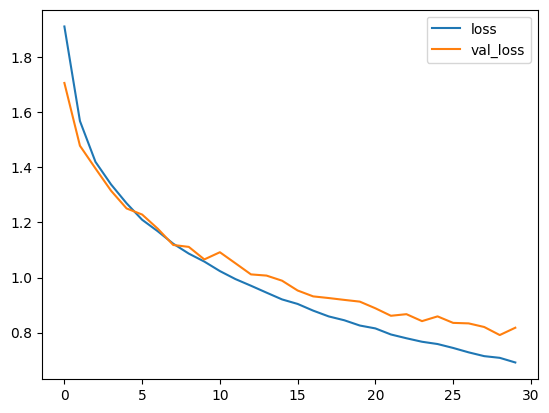

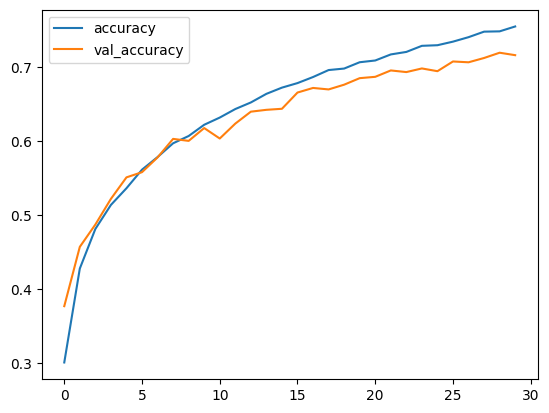

In [15]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [38]:
def score_to_viz(chunk_score):
    # get the most attended token
    chunk_viz = ops.max(chunk_score, axis=-2)
    # get the mean across heads
    chunk_viz = ops.mean(chunk_viz, axis=1)
    return chunk_viz


# Get a batch of images and labels from the testing dataset
images, labels = next(iter(test_ds))

# Create a new model instance that is executed eagerly to allow saving
# attention scores. This also requires unrolling loops
eager_model = TemporalLatentBottleneckModel(
    patch_layer=patch_layer, custom_cell=custom_rnn_cell, unroll_loops=True
)
eager_model.build(input_shape=config["input_shape"])

eager_model.compile(run_eagerly=True, jit_compile=False)
model.save("weights.keras")
eager_model.load_weights("weights.keras")

# Set the get_attn_scores flag to True
eager_model.rnn.cell.get_attention_scores = True

# Run the model with the testing images and grab the
# attention scores.
outputs = eager_model(images)
list_chunk_scores = eager_model.rnn.cell.attention_scores

# Process the attention scores in order to visualize them
num_chunks = (config["image_size"] // config["patch_size"]) ** 2 // config["chunk_size"]
list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores[-num_chunks:]]
chunk_viz = ops.concatenate(list_chunk_viz, axis=-1)
chunk_viz = ops.reshape(
    chunk_viz,
    (
        config["batch_size"],
        config["image_size"] // config["patch_size"],
        config["image_size"] // config["patch_size"],
        1,
    ),
)
upsampled_heat_map = layers.UpSampling2D(
    size=(4, 4), interpolation="bilinear", dtype="float32"
)(chunk_viz)

/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'temporal_latent_bottleneck_model_17', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


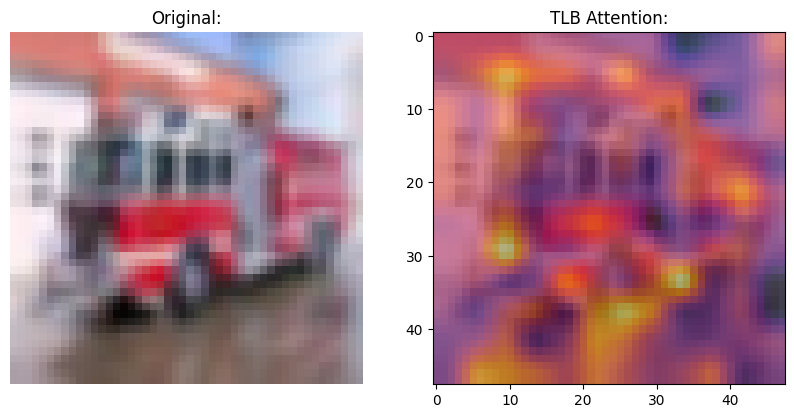

In [39]:
# Sample a random image
index = random.randint(0, config["batch_size"])
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

if keras.backend.backend() == "torch":
    # when using the torch backend, we are required to ensure that the
    # image is copied from the GPU
    orig_image = orig_image.cpu().detach().numpy()
    overlay_image = overlay_image.cpu().detach().numpy()

# Plot the visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(
    overlay_image,
    cmap="inferno",
    alpha=0.6,
    extent=image.get_extent(),
)
ax[1].set_title("TLB Attention:")

plt.show()